In [5]:
# === 0) Importy knihoven ===
from datasets import Dataset, ClassLabel
import pandas as pd
import re
from transformers import (
    RobertaTokenizer, RobertaForSequenceClassification,
    Trainer, TrainingArguments, DataCollatorWithPadding
)
import torch
import torch.nn as nn
from collections import Counter
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
import numpy as np

# ============================================
# 1️ Načtení CSV datasetu
# ============================================
df2 = pd.read_csv("empathetic_dialogues.csv")
df2['text'] = df2['Situation'].fillna('') + " " + df2['empathetic_dialogues'].fillna('')

# ============================================
# 2️ Mapování emocí do 3 tříd
# ============================================
emotion2label = {
    # Negative
    "sad": 0, "angry": 0, "afraid": 0, "anxious": 0, "ashamed": 0, "disgusted": 0,
    "embarrassed": 0, "guilty": 0, "jealous": 0, "lonely": 0, "disappointed": 0,
    "terrified": 0, "nostalgic": 0, "devastated": 0, "annoyed": 0,
    # Neutral
    "neutral": 1, "surprised": 1, "confused": 1, "anticipating": 1, "apprehensive": 1,
    "hopeful": 1, "caring": 1, "sentimental": 1,
    # Positive
    "happy": 2, "excited": 2, "content": 2, "grateful": 2, "proud": 2, "impressed": 2,
    "joyful": 2, "trusting": 2, "prepared": 2, "confident": 2
}

df2['label'] = df2['emotion'].map(emotion2label).fillna(1).astype(int)
ds2 = Dataset.from_pandas(df2[['text', 'label']])

# ============================================
# 3️ Maskování citlivých údajů
# ============================================
def mask_sensitive(text: str) -> str:
    if not isinstance(text, str):
        return ""
    text = re.sub(r"\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Z|a-z]{2,}\b", "<EMAIL>", text)
    text = re.sub(r"http\S+|www\.\S+", "<URL>", text)
    text = re.sub(r"\+?\d[\d\-\s]{7,}\d", "<PHONE>", text)
    text = re.sub(r"@[A-Za-z0-9_]+", "<USER>", text)
    text = re.sub(r"\b\d{4,}\b", "<NUMBER>", text)
    text = re.sub(r"(?<![.!?]\s)(?<!^)(\b[A-Z][a-z]+)", "<NAME>", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

ds2_clean = ds2.map(lambda x: {'text': mask_sensitive(x['text']), 'label': x['label']})
ds2_clean = ds2_clean.filter(lambda x: len(x['text']) > 5)

# ============================================
# 4️ Tokenizace
# ============================================
tokenizer = RobertaTokenizer.from_pretrained("roberta-base")
def tokenize(batch):
    return tokenizer(batch["text"], padding="max_length", truncation=True, max_length=128)

new_features = ds2_clean.features.copy()
new_features['label'] = ClassLabel(names=["Negative", "Neutral", "Positive"])
ds2_clean = ds2_clean.cast(new_features)
tokenized_ds2 = ds2_clean.map(tokenize, batched=True)

# ============================================
# 5️ Rozdělení datasetu
# ============================================
split_ds2 = tokenized_ds2.train_test_split(test_size=0.2, stratify_by_column="label", seed=42)
train_ds2 = split_ds2['train']
testval_ds2 = split_ds2['test'].train_test_split(test_size=0.5, stratify_by_column="label", seed=42)
valid_ds2 = testval_ds2['train']
test_ds2 = testval_ds2['test']

print(f"Train samples: {len(train_ds2)}, Validation: {len(valid_ds2)}, Test: {len(test_ds2)}")

# ============================================
# 6️ Výpočet vah tříd
# ============================================
def compute_class_weights(dataset, num_labels=3):
    counter = Counter(dataset['label'])
    total = sum(counter.values())
    weights = []
    for i in range(num_labels):
        if counter[i] > 0:
            weights.append(total / (num_labels * counter[i]))
        else:
            avg_weight = total / (num_labels * (sum(c > 0 for c in counter.values())))
            weights.append(avg_weight)
    weights = torch.tensor(weights, dtype=torch.float)
    return weights / weights.sum() * num_labels

class_weights2 = compute_class_weights(train_ds2)
print("Vypočtené váhy tříd:", class_weights2.tolist())

# ============================================
# 7️ Data Collator
# ============================================
data_collator = DataCollatorWithPadding(tokenizer)

# ============================================
# 8️ Načtení modelu z předchozího tréninku
# ============================================
model = RobertaForSequenceClassification.from_pretrained("./roberta-sentiment_dataset1", num_labels=3)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# ============================================
# 9️ Custom Weighted Trainer
# ============================================
class WeightedTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.get("labels").to(device)
        outputs = model(**inputs)
        logits = outputs.get("logits")
        loss_fct = nn.CrossEntropyLoss(weight=class_weights2.to(device))
        loss = loss_fct(logits, labels)
        return (loss, outputs) if return_outputs else loss

# ============================================
# 1️0️ TrainingArguments
# ============================================
training_args2 = TrainingArguments(
    output_dir="./roberta-sentiment_dataset2v2",
    overwrite_output_dir=True,
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir="./logs_empathetic",
    logging_steps=100,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    greater_is_better=True,
    save_total_limit=2,
    seed=42,
)

# ============================================
# 1️1️ Inicializace Traineru
# ============================================
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    return {
        "accuracy": accuracy_score(labels, preds),
        "precision": precision_score(labels, preds, average="weighted"),
        "recall": recall_score(labels, preds, average="weighted"),
        "f1": f1_score(labels, preds, average="weighted"),
    }

trainer2 = WeightedTrainer(
    model=model,
    args=training_args2,
    train_dataset=train_ds2,
    eval_dataset=valid_ds2,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

# ============================================
# 1️2️ Fine-tuning
# ============================================
trainer2.train()
trainer2.save_model("./roberta-sentiment_dataset2v2")
tokenizer.save_pretrained("./roberta-sentiment_dataset2v2")

# ============================================
# 1️3️ Vyhodnocení na testovací sadě
# ============================================
metrics2 = trainer2.evaluate(test_ds2)
print("\n📊 Výsledky na testovacích datech (Empathetic Dialogues):")
for k, v in metrics2.items():
    print(f"{k:<12}: {v:.4f}")


Map:   0%|          | 0/64636 [00:00<?, ? examples/s]

Filter:   0%|          | 0/64636 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/64636 [00:00<?, ? examples/s]

Map:   0%|          | 0/64636 [00:00<?, ? examples/s]

Train samples: 51708, Validation: 6464, Test: 6464
Vypočtené váhy tříd: [0.6547132730484009, 1.26151442527771, 1.0837723016738892]


TypeError: TrainingArguments.__init__() got an unexpected keyword argument 'evaluation_strategy'

In [5]:
pip install --upgrade transformers

Note: you may need to restart the kernel to use updated packages.


In [3]:
import transformers
print(transformers.__version__)

4.57.1


Map:   0%|          | 0/64636 [00:00<?, ? examples/s]

Filter:   0%|          | 0/64636 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/64636 [00:00<?, ? examples/s]

Map:   0%|          | 0/64636 [00:00<?, ? examples/s]

Train samples: 51708, Validation: 6464, Test: 6464

Train - Statistika tříd:
  Negative: 24355 (47.10%)
  Neutral : 12640 (24.44%)
  Positive: 14713 (28.45%)


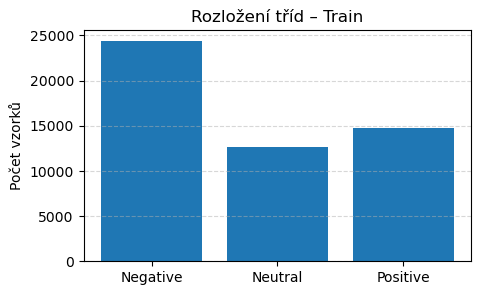


Validation - Statistika tříd:
  Negative:  3045 (47.11%)
  Neutral :  1580 (24.44%)
  Positive:  1839 (28.45%)


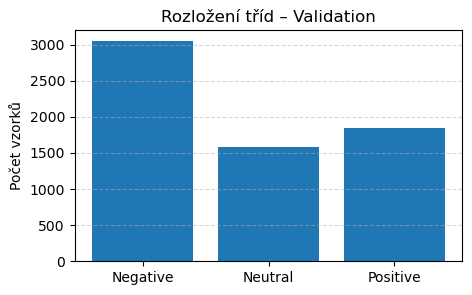


Test - Statistika tříd:
  Negative:  3044 (47.09%)
  Neutral :  1580 (24.44%)
  Positive:  1840 (28.47%)


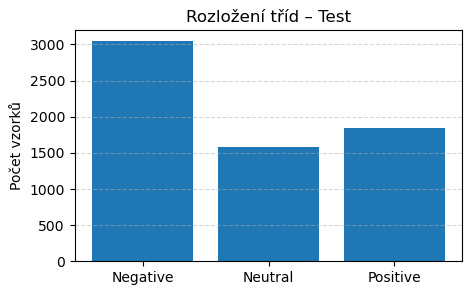

Vypočtené váhy tříd: [0.6547132730484009, 1.26151442527771, 1.0837723016738892]


/tmp/ipykernel_2198/394198652.py:185: UserWarning: load_best_model_at_end disabled because evaluation/save strategy not compatible.
  warnings.warn("load_best_model_at_end disabled because evaluation/save strategy not compatible.")
/tmp/ipykernel_2198/394198652.py:205: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  trainer2 = WeightedTrainer(


Step,Training Loss
100,0.959700
200,0.745200
300,0.680800
400,0.662000
500,0.604700
600,0.593600
700,0.579100
800,0.581600
900,0.512300
1000,0.553600



📊 Výsledky na testovacích datech (Empathetic Dialogues):
eval_loss   : 0.2030
eval_accuracy: 0.9561
eval_precision: 0.9560
eval_recall : 0.9561
eval_f1     : 0.9560
eval_runtime: 12.2076
eval_samples_per_second: 529.5060
eval_steps_per_second: 33.0940
epoch       : 3.0000


In [6]:
from datasets import Dataset, ClassLabel
import pandas as pd
import re
from transformers import (
    RobertaTokenizer, RobertaForSequenceClassification,
    Trainer, TrainingArguments, DataCollatorWithPadding
)
import torch
import torch.nn as nn
from collections import Counter
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
import numpy as np
import inspect
import warnings
import matplotlib.pyplot as plt

# ============================================
# 1️) Načtení CSV datasetu
# ============================================
df2 = pd.read_csv("empathetic_dialogues.csv")
df2['text'] = df2['Situation'].fillna('') + " " + df2['empathetic_dialogues'].fillna('')

# ============================================
# 2️) Mapování emocí do 3 tříd
# ============================================
emotion2label = {
    # Negative
    "sad": 0, "angry": 0, "afraid": 0, "anxious": 0, "ashamed": 0, "disgusted": 0,
    "embarrassed": 0, "guilty": 0, "jealous": 0, "lonely": 0, "disappointed": 0,
    "terrified": 0, "nostalgic": 0, "devastated": 0, "annoyed": 0,
    # Neutral
    "neutral": 1, "surprised": 1, "confused": 1, "anticipating": 1, "apprehensive": 1,
    "hopeful": 1, "caring": 1, "sentimental": 1,
    # Positive
    "happy": 2, "excited": 2, "content": 2, "grateful": 2, "proud": 2, "impressed": 2,
    "joyful": 2, "trusting": 2, "prepared": 2, "confident": 2
}
df2['label'] = df2['emotion'].map(emotion2label).fillna(1).astype(int)
ds2 = Dataset.from_pandas(df2[['text', 'label']])

# ============================================
# 3️) Anonymizace
# ============================================
def mask_sensitive(text: str) -> str:
    if not isinstance(text, str):
        return ""
    text = re.sub(r"\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Z|a-z]{2,}\b", "<EMAIL>", text)
    text = re.sub(r"http\S+|www\.\S+", "<URL>", text)
    text = re.sub(r"\+?\d[\d\-\s]{7,}\d", "<PHONE>", text)
    text = re.sub(r"@[A-Za-z0-9_]+", "<USER>", text)
    text = re.sub(r"\b\d{4,}\b", "<NUMBER>", text)
    text = re.sub(r"(?<![.!?]\s)(?<!^)(\b[A-Z][a-z]+)", "<NAME>", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

ds2_clean = ds2.map(lambda x: {'text': mask_sensitive(x['text']), 'label': x['label']})
ds2_clean = ds2_clean.filter(lambda x: len(x['text']) > 5)

# ============================================
# 4️) Tokenizace
# ============================================
tokenizer = RobertaTokenizer.from_pretrained("roberta-base")
def tokenize(batch):
    return tokenizer(batch["text"], padding="max_length", truncation=True, max_length=128)

new_features = ds2_clean.features.copy()
new_features['label'] = ClassLabel(names=["Negative", "Neutral", "Positive"])
ds2_clean = ds2_clean.cast(new_features)
tokenized_ds2 = ds2_clean.map(tokenize, batched=True)

# ============================================
# 5️) Rozdělení datasetu
# ============================================
split_ds2 = tokenized_ds2.train_test_split(test_size=0.2, stratify_by_column="label", seed=42)
train_ds2 = split_ds2['train']
testval_ds2 = split_ds2['test'].train_test_split(test_size=0.5, stratify_by_column="label", seed=42)
valid_ds2 = testval_ds2['train']
test_ds2 = testval_ds2['test']

print(f"Train samples: {len(train_ds2)}, Validation: {len(valid_ds2)}, Test: {len(test_ds2)}")

# ============================================
# 6️) Vizualizace rozložení tříd
# ============================================
def show_label_stats(dataset, name="Dataset"):
    labels = list(dataset["label"])
    counts = Counter(labels)
    total = sum(counts.values())
    label_names = ["Negative", "Neutral", "Positive"]
    print(f"\n{name} - Statistika tříd:")
    for i, count in sorted(counts.items()):
        perc = (count / total) * 100
        print(f"  {label_names[i]:<8}: {count:5d} ({perc:5.2f}%)")
    plt.figure(figsize=(5,3))
    plt.bar(label_names, [counts.get(i,0) for i in range(3)])
    plt.title(f"Rozložení tříd – {name}")
    plt.ylabel("Počet vzorků")
    plt.grid(axis="y", linestyle="--", alpha=0.5)
    plt.show()

show_label_stats(train_ds2, "Train")
show_label_stats(valid_ds2, "Validation")
show_label_stats(test_ds2, "Test")

# ============================================
# 7️) Výpočet vah tříd
# ============================================
def compute_class_weights(dataset, num_labels=3):
    counter = Counter(dataset['label'])
    total = sum(counter.values())
    weights = []
    for i in range(num_labels):
        if counter[i] > 0:
            weights.append(total / (num_labels * counter[i]))
        else:
            avg_weight = total / (num_labels * (sum(c > 0 for c in counter.values())))
            weights.append(avg_weight)
    weights = torch.tensor(weights, dtype=torch.float)
    return weights / weights.sum() * num_labels

class_weights2 = compute_class_weights(train_ds2)
print("Vypočtené váhy tříd:", class_weights2.tolist())

# ============================================
# 8️) Data Collator a model
# ============================================
data_collator = DataCollatorWithPadding(tokenizer)
model = RobertaForSequenceClassification.from_pretrained("./roberta-sentiment_dataset1", num_labels=3)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# ============================================
# 9️) Custom Weighted Trainer
# ============================================
class WeightedTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.get("labels").to(device)
        outputs = model(**inputs)
        logits = outputs.get("logits")
        loss_fct = nn.CrossEntropyLoss(weight=class_weights2.to(device))
        loss = loss_fct(logits, labels)
        return (loss, outputs) if return_outputs else loss

# ============================================
# 10️) Kompatibilní TrainingArguments
# ============================================
requested_args = {
    "output_dir": "./roberta-sentiment_dataset2v2",
    "overwrite_output_dir": True,
    "num_train_epochs": 3,
    "per_device_train_batch_size": 16,
    "per_device_eval_batch_size": 16,
    "learning_rate": 2e-5,
    "weight_decay": 0.01,
    "logging_dir": "./logs_empathetic",
    "logging_steps": 100,
    "evaluation_strategy": "epoch",
    "save_strategy": "epoch",
    "load_best_model_at_end": True,
    "metric_for_best_model": "f1",
    "greater_is_better": True,
    "save_total_limit": 2,
    "seed": 42,
}

sig = inspect.signature(TrainingArguments.__init__)
supported = set(sig.parameters.keys())
args_to_pass = {k: v for k, v in requested_args.items() if k in supported}

if "evaluation_strategy" not in supported or "save_strategy" not in supported:
    per_device = args_to_pass.get("per_device_train_batch_size", 16)
    steps_per_epoch = max(1, len(train_ds2) // max(1, per_device))
    if "eval_steps" in supported:
        args_to_pass["eval_steps"] = steps_per_epoch
    if "save_steps" in supported:
        args_to_pass["save_steps"] = steps_per_epoch
    if "load_best_model_at_end" in args_to_pass:
        args_to_pass["load_best_model_at_end"] = False
        warnings.warn("load_best_model_at_end disabled because evaluation/save strategy not compatible.")

training_args2 = TrainingArguments(**args_to_pass)

# ============================================
# 11) Metriky
# ============================================
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    return {
        "accuracy": accuracy_score(labels, preds),
        "precision": precision_score(labels, preds, average="weighted", zero_division=0),
        "recall": recall_score(labels, preds, average="weighted", zero_division=0),
        "f1": f1_score(labels, preds, average="weighted", zero_division=0),
    }

# ============================================
# 12) Inicializace Traineru a trénink
# ============================================
trainer2 = WeightedTrainer(
    model=model,
    args=training_args2,
    train_dataset=train_ds2,
    eval_dataset=valid_ds2,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

trainer2.train()
trainer2.save_model("./roberta-sentiment_dataset2v2")
tokenizer.save_pretrained("./roberta-sentiment_dataset2v2")

# ============================================
# 13) Vyhodnocení na testovacích datech
# ============================================
metrics2 = trainer2.evaluate(test_ds2)
print("\n📊 Výsledky na testovacích datech (Empathetic Dialogues):")
for k, v in metrics2.items():
    print(f"{k:<12}: {v:.4f}")


In [11]:
from transformers import pipeline, RobertaTokenizer, RobertaForSequenceClassification
import torch

# Načtení modelu a tokenizeru
model_path = "./roberta-sentiment_dataset2v2"
tokenizer = RobertaTokenizer.from_pretrained(model_path)
model = RobertaForSequenceClassification.from_pretrained(model_path)
device = 0 if torch.cuda.is_available() else -1

sentiment_pipe = pipeline(
    "text-classification",
    model=model,
    tokenizer=tokenizer,
    return_all_scores=True,   # pro zobrazení všech tří tříd
    device=device
)

# Test na několika větách
sample_texts = [
    "I am so happy today! Everything went perfectly.",
    "I feel so sad and disappointed.",
    "It's just an ordinary day, nothing special happened.",
    "I'm frustrated and angry about this situation.",
    "I'm nervous about tomorrow's meeting."
]

print("\n=== SAMPLE INFERENCE ===\n")
for text in sample_texts:
    scores = sentiment_pipe(text)[0]
    print(f"Text: {text}")
    for score in scores:
        label = score['label']
        value = score['score']
      
        print(f"  {label}: {value:.4f}")
    print()


Device set to use cuda:0



=== SAMPLE INFERENCE ===

Text: I am so happy today! Everything went perfectly.
  Negative: 0.0001
  Neutral: 0.0009
  Positive: 0.9990

Text: I feel so sad and disappointed.
  Negative: 0.9987
  Neutral: 0.0012
  Positive: 0.0001

Text: It's just an ordinary day, nothing special happened.
  Negative: 0.0100
  Neutral: 0.4221
  Positive: 0.5678

Text: I'm frustrated and angry about this situation.
  Negative: 0.9957
  Neutral: 0.0041
  Positive: 0.0002

Text: I'm nervous about tomorrow's meeting.
  Negative: 0.9892
  Neutral: 0.0105
  Positive: 0.0003



In [10]:
from transformers import pipeline, RobertaTokenizer, RobertaForSequenceClassification
import torch

# Načtení modelu a tokenizeru
model_path = "./roberta-sentiment_dataset1"
tokenizer = RobertaTokenizer.from_pretrained(model_path)
model = RobertaForSequenceClassification.from_pretrained(model_path)
device = 0 if torch.cuda.is_available() else -1

sentiment_pipe = pipeline(
    "text-classification",
    model=model,
    tokenizer=tokenizer,
    return_all_scores=True,   # pro zobrazení všech tří tříd
    device=device
)

# Test na několika větách
sample_texts = [
    "I am so happy today! Everything went perfectly.",
    "I feel so sad and disappointed.",
    "It's just an ordinary day, nothing special happened.",
    "I'm frustrated and angry about this situation.",
    "I'm nervous about tomorrow's meeting."
]

print("\n=== SAMPLE INFERENCE ===\n")
for text in sample_texts:
    scores = sentiment_pipe(text)[0]
    print(f"Text: {text}")
    for score in scores:
        label = score['label']
        value = score['score']
        
        print(f"  {label}: {value:.4f}")
    print()


Device set to use cuda:0



=== SAMPLE INFERENCE ===

Text: I am so happy today! Everything went perfectly.
  Negative: 0.0005
  Neutral: 0.0039
  Positive: 0.9956

Text: I feel so sad and disappointed.
  Negative: 0.9946
  Neutral: 0.0049
  Positive: 0.0005

Text: It's just an ordinary day, nothing special happened.
  Negative: 0.0045
  Neutral: 0.9931
  Positive: 0.0024

Text: I'm frustrated and angry about this situation.
  Negative: 0.0524
  Neutral: 0.9457
  Positive: 0.0019

Text: I'm nervous about tomorrow's meeting.
  Negative: 0.4178
  Neutral: 0.5802
  Positive: 0.0020



In [ ]:
# ============================================
# 10) Kompatibilní sestavení TrainingArguments – Empathetic Dialogues
# ============================================
import inspect
import warnings

requested_args = {
    "output_dir": "./roberta-sentiment_dataset2v2",
    "overwrite_output_dir": True,
    "num_train_epochs": 3,
    "per_device_train_batch_size": 16,
    "per_device_eval_batch_size": 16,
    "learning_rate": 2e-5,
    "weight_decay": 0.01,
    "logging_dir": "./logs_empathetic",
    "logging_steps": 100,
    "evaluation_strategy": "epoch",
    "save_strategy": "epoch",
    "load_best_model_at_end": True,
    "metric_for_best_model": "f1",
    "greater_is_better": True,
    "save_total_limit": 2,
    "seed": 42,
}

# zjistíme, které parametry TrainingArguments opravdu akceptuje
sig = inspect.signature(TrainingArguments.__init__)
supported = set(sig.parameters.keys())

args_to_pass = {}
for k, v in requested_args.items():
    if k in supported:
        args_to_pass[k] = v

# pokud evaluation_strategy/save_strategy nejsou podporovány, nastavíme eval_steps/save_steps
if "evaluation_strategy" not in supported or "save_strategy" not in supported:
    per_device = args_to_pass.get("per_device_train_batch_size", 16)
    steps_per_epoch = max(1, len(train_ds2) // max(1, per_device))
    if "eval_steps" in supported:
        args_to_pass["eval_steps"] = steps_per_epoch
    if "save_steps" in supported:
        args_to_pass["save_steps"] = steps_per_epoch
    if "load_best_model_at_end" in args_to_pass:
        args_to_pass["load_best_model_at_end"] = False
        warnings.warn("load_best_model_at_end disabled because evaluation/save strategy not compatible.")

print("Parametry předané do TrainingArguments:")
for k in sorted(args_to_pass.keys()):
    print(f"  {k}: {args_to_pass[k]}")

training_args2 = TrainingArguments(**args_to_pass)


Loading model and tokenizer...


Device set to use cuda:0



=== SAMPLE INFERENCE ===

Text: I am so happy today! Everything went perfectly.
  Positive: 0.9990
  Neutral: 0.0009
  Negative: 0.0001

Text: I feel so sad and disappointed.
  Negative: 0.9988
  Neutral: 0.0011
  Positive: 0.0001

Text: It's just an ordinary day, nothing special happened.
  Positive: 0.9807
  Neutral: 0.0167
  Negative: 0.0026

Text: I'm frustrated and angry about this situation.
  Negative: 0.9988
  Neutral: 0.0011
  Positive: 0.0001

Text: I'm nervous about tomorrow's meeting.
  Negative: 0.9945
  Neutral: 0.0053
  Positive: 0.0002

Text: It is normal situation.
  Positive: 0.9710
  Neutral: 0.0206
  Negative: 0.0083

=== EVALUATION ON TEST DATASET ===
Accuracy : 0.9561
Precision: 0.9560
Recall   : 0.9561
F1 Score : 0.9560


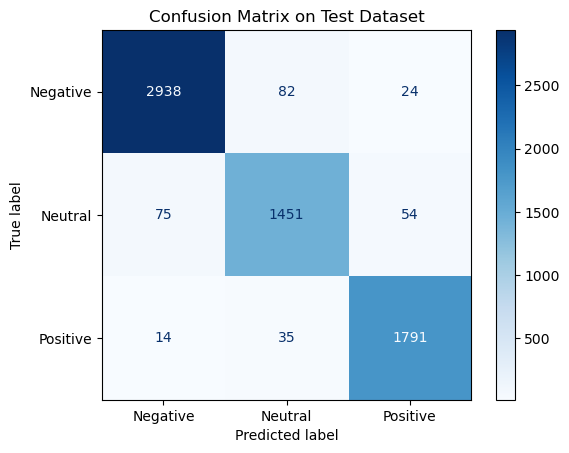


Saving detailed results to 'model_predictions.csv' ...
File saved: model_predictions.csv


In [12]:
#test na datasetu
from transformers import pipeline
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch

# 1️ Načtení modelu a tokenizeru
model_path = "./roberta-sentiment_dataset2"
tokenizer_name = "roberta-base"

print("Loading model and tokenizer...")
sentiment_pipe = pipeline(
    "text-classification",
    model=model_path,
    tokenizer=tokenizer_name,
    return_all_scores=True,
    device=0 if torch.cuda.is_available() else -1
)

# 2️ Test inference – kontrola na několika vlastních větách
sample_texts = [
    "I am so happy today! Everything went perfectly.",
    "I feel so sad and disappointed.",
    "It's just an ordinary day, nothing special happened.",
    "I'm frustrated and angry about this situation.",
    "I'm nervous about tomorrow's meeting.",
    "It is normal situation."
]

print("\n=== SAMPLE INFERENCE ===")
for text in sample_texts:
    preds = sentiment_pipe(text)[0]
    preds_sorted = sorted(preds, key=lambda x: x['score'], reverse=True)
    print(f"\nText: {text}")
    for p in preds_sorted:
        print(f"  {p['label']}: {p['score']:.4f}")

# 3️ Vyhodnocení na testovacím datasetu (pokud máš test_ds2 z paměti)
try:
    print("\n=== EVALUATION ON TEST DATASET ===")
    predictions = trainer2.predict(test_ds2)
    y_true = predictions.label_ids
    y_pred = np.argmax(predictions.predictions, axis=-1)

    # Metriky
    from sklearn.metrics import accuracy_score, precision_recall_fscore_support

    acc = accuracy_score(y_true, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")

    print(f"Accuracy : {acc:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall   : {recall:.4f}")
    print(f"F1 Score : {f1:.4f}")

    # 4️ Matice záměn
    labels = ["Negative", "Neutral", "Positive"]
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues")
    plt.title("Confusion Matrix on Test Dataset")
    plt.show()

    # 5️ Uložení výsledků do CSV
    print("\nSaving detailed results to 'model_predictions.csv' ...")
    df_results = pd.DataFrame({
        "text": test_ds2["text"],
        "true_label": [labels[i] for i in y_true],
        "pred_label": [labels[i] for i in y_pred]
    })
    df_results.to_csv("model_predictions_2.csv", index=False)
    print("File saved: model_predictions.csv")

except NameError:
    print("\n Variable 'trainer2' or 'test_ds2' not found. Please make sure to load your dataset and trainer first.")


Loading model and tokenizer...


Device set to use cuda:0



=== SAMPLE INFERENCE ===

Text: I am so happy today! Everything went perfectly.
  Positive: 0.9990
  Neutral: 0.0009
  Negative: 0.0001

Text: I feel so sad and disappointed.
  Negative: 0.9987
  Neutral: 0.0012
  Positive: 0.0001

Text: It's just an ordinary day, nothing special happened.
  Positive: 0.5678
  Neutral: 0.4221
  Negative: 0.0100

Text: I'm frustrated and angry about this situation.
  Negative: 0.9957
  Neutral: 0.0041
  Positive: 0.0002

Text: I'm nervous about tomorrow's meeting.
  Negative: 0.9892
  Neutral: 0.0105
  Positive: 0.0003

Text: It is normal situation.
  Positive: 0.9644
  Neutral: 0.0339
  Negative: 0.0017

=== EVALUATION ON TEST DATASET ===


Accuracy : 0.9561
Precision: 0.9560
Recall   : 0.9561
F1 Score : 0.9560


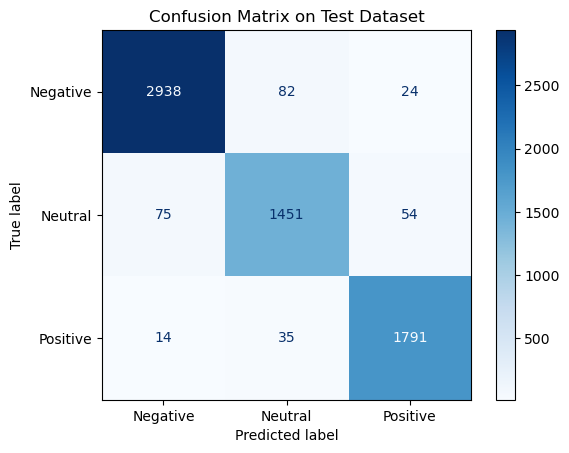


Saving detailed results to 'model_predictions.csv' ...
File saved: model_predictions.csv


In [14]:
#test na datasetu
from transformers import pipeline
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch

# 1️ Načtení modelu a tokenizeru
model_path = "./roberta-sentiment_dataset2v2"
tokenizer_name = "roberta-base"

print("Loading model and tokenizer...")
sentiment_pipe = pipeline(
    "text-classification",
    model=model_path,
    tokenizer=tokenizer_name,
    return_all_scores=True,
    device=0 if torch.cuda.is_available() else -1
)

# 2️ Test inference – kontrola na několika vlastních větách
sample_texts = [
    "I am so happy today! Everything went perfectly.",
    "I feel so sad and disappointed.",
    "It's just an ordinary day, nothing special happened.",
    "I'm frustrated and angry about this situation.",
    "I'm nervous about tomorrow's meeting.",
    "It is normal situation."
]

print("\n=== SAMPLE INFERENCE ===")
for text in sample_texts:
    preds = sentiment_pipe(text)[0]
    preds_sorted = sorted(preds, key=lambda x: x['score'], reverse=True)
    print(f"\nText: {text}")
    for p in preds_sorted:
        print(f"  {p['label']}: {p['score']:.4f}")

# 3️ Vyhodnocení na testovacím datasetu (pokud máš test_ds2 z paměti)
try:
    print("\n=== EVALUATION ON TEST DATASET ===")
    predictions = trainer2.predict(test_ds2)
    y_true = predictions.label_ids
    y_pred = np.argmax(predictions.predictions, axis=-1)

    # Metriky
    from sklearn.metrics import accuracy_score, precision_recall_fscore_support

    acc = accuracy_score(y_true, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")

    print(f"Accuracy : {acc:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall   : {recall:.4f}")
    print(f"F1 Score : {f1:.4f}")

    # 4️ Matice záměn
    labels = ["Negative", "Neutral", "Positive"]
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues")
    plt.title("Confusion Matrix on Test Dataset")
    plt.show()

    # 5️ Uložení výsledků do CSV
    print("\nSaving detailed results to 'model_predictions.csv' ...")
    df_results = pd.DataFrame({
        "text": test_ds2["text"],
        "true_label": [labels[i] for i in y_true],
        "pred_label": [labels[i] for i in y_pred]
    })
    df_results.to_csv("model_predictions_2.csv", index=False)
    print("File saved: model_predictions.csv")

except NameError:
    print("\n Variable 'trainer2' or 'test_ds2' not found. Please make sure to load your dataset and trainer first.")
